In [1]:
!git clone https://github.com/Glen-Chue/Image-Classifier-with-VGG16-transfer-Learning.git

Cloning into 'Image-Classifier-with-VGG16-transfer-Learning'...
remote: Enumerating objects: 9899, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9899 (delta 1), reused 11 (delta 1), pack-reused 9888
Receiving objects: 100% (9899/9899), 524.58 MiB | 35.58 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (9999/9999), done.


In [2]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import Adam
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Defining Relevant Preprocessing Steps**

In [3]:
#Transformers 
transformer_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, fill=0),
    transforms.RandomRotation(45),
    transforms.RandomGrayscale(p=0.9),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transformer_test = transforms.Compose([
    transforms.Resize((224,224)),
    #transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    #transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, fill=0),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

**Loading the Datasets**

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform = None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file,sep = ' ',header=None)
        self.img_labels.columns = ['Image' , 'Label']
        self.img_labels = self.img_labels[self.img_labels['Label']<=10]
        self.transform = transform
        self.target_transform = target_transform
        self.n_classes = 11

    def __len__(self):
        return len(self.img_labels)


    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = read_image(img_path).float()
        image = image / 255.0
        if image.shape[0] == 3:
            image = image[:3]
        elif image.shape[0] == 1:
            image = image.repeat(3, 1, 1)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
original_train = CustomImageDataset('/content/Image-Classifier-with-VGG16-transfer-Learning/train.txt',transform = transformer_test)
transformed_train = CustomImageDataset('/content/Image-Classifier-with-VGG16-transfer-Learning/train.txt',transform = transformer_train)
train = torch.utils.data.ConcatDataset([transformed_train,original_train])
#train = CustomImageDataset('/content/Image-Classifier-with-VGG16-transfer-Learning/train.txt',transform = transformer_test)

In [6]:
test = CustomImageDataset('/content/Image-Classifier-with-VGG16-transfer-Learning/test.txt',transform = transformer_test)

In [7]:
train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=1, shuffle=True)

In [8]:
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


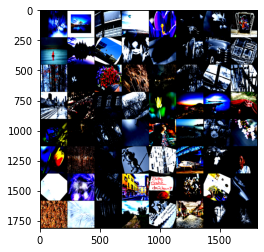

In [9]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


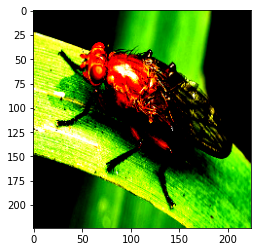

In [10]:
# Get a batch of training data
inputs, classes = next(iter(test_loader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)

**Fine Tuning**

Defining Helper Functions

In [11]:
import torchvision.models as models
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    #loss = Variable(loss, requires_grad = True)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

Initializing Pre - Trained Model

In [12]:
# load pre-trained model
conv_base = models.resnet50(pretrained=True)

for param in conv_base.parameters():
    param.requires_grad = False

conv_base.fc = nn.Sequential(nn.Linear(2048, 11))
                                 #nn.ReLU(),
                                 #nn.Dropout(0.2),
                                 #nn.Linear(512, 11))
                                 #nn.ReLU(),
                                 #nn.Dropout(0.2),
                                 #nn.Linear(128, 20))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [13]:
# Create training and validation dataloaders
dataloaders_dict = {'train':train_loader , 'val':test_loader}
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Send the model to GPU
model_ft = conv_base.to(device)

In [14]:
from torch import optim
params_to_update = model_ft.parameters()
print("Params to learn:")
feature_extract = True
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(params_to_update)


Params to learn:
	 fc.0.weight
	 fc.0.bias


Extracting Features from Pre - Trained Model and using them for prediction

In [ ]:
import time,copy
# Setup the loss fxn1
criterion = nn.CrossEntropyLoss()
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=25, is_inception=False)

Epoch 0/24
----------


# Hyperparameter Tuning with Optuna

In [ ]:
print(5)

5


# Model Inference

In [ ]:
! wget http://virtualization.com/wp-content/uploads/2008/03/virtualization-kvm-ubuntu.png

--2022-04-28 10:21:29--  http://virtualization.com/wp-content/uploads/2008/03/virtualization-kvm-ubuntu.png
Resolving virtualization.com (virtualization.com)... 72.47.224.111
Connecting to virtualization.com (virtualization.com)|72.47.224.111|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5857 (5.7K) [image/png]
Saving to: ‘virtualization-kvm-ubuntu.png’

virtualization-kvm- 100%[===================>]   5.72K  --.-KB/s    in 0s      

2022-04-28 10:21:29 (233 MB/s) - ‘virtualization-kvm-ubuntu.png’ saved [5857/5857]



In [ ]:
from PIL import Image
img = Image.open("/content/virtualization-kvm-ubuntu.png").convert('RGB')
img = img.save("/content/final.jpg")
img = read_image("/content/final.jpg").float()
img = img/255.0
img_t = transformer_test(img)     
img_t = img_t.unsqueeze(0) 

In [ ]:
img_t = img_t.cuda()
infer = model_ft(img_t)

In [ ]:
infer.topk(5)

torch.return_types.topk(values=tensor([[2.9645, 2.1249, 2.0827, 1.0095, 0.5929]], device='cuda:0',
       grad_fn=<TopkBackward0>), indices=tensor([[1, 3, 2, 5, 4]], device='cuda:0'))